# Multi Class Classification Problem

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score,recall_score,precision_score
from lightgbm import LGBMClassifier
from urllib.parse import urlparse
from sklearn.model_selection import train_test_split 
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn import preprocessing 
import pickle

In [3]:
import mlflow

In [4]:
mlflow.set_experiment('air pollution exep')

<Experiment: artifact_location='file:///D:/MLOPS/Air%20pollution/mlruns/6', creation_time=1738063476931, experiment_id='6', last_update_time=1738063476931, lifecycle_stage='active', name='air pollution exep', tags={}>

In [5]:
data=pd.read_csv("dataset/updated_pollution_dataset.csv")
copy=data.copy()

# Data analyze

In [11]:
data.shape

(5000, 10)

Check for feature types and null values:

All columns are numerical, only for the Air Quality column that is an Object.

There are no null values.

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 10 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Temperature                    5000 non-null   float64
 1   Humidity                       5000 non-null   float64
 2   PM2.5                          5000 non-null   float64
 3   PM10                           5000 non-null   float64
 4   NO2                            5000 non-null   float64
 5   SO2                            5000 non-null   float64
 6   CO                             5000 non-null   float64
 7   Proximity_to_Industrial_Areas  5000 non-null   float64
 8   Population_Density             5000 non-null   int64  
 9   Air Quality                    5000 non-null   object 
dtypes: float64(8), int64(1), object(1)
memory usage: 390.8+ KB


In [13]:
data['Air Quality'].value_counts()
#data is not balanced

Good         2000
Moderate     1500
Poor         1000
Hazardous     500
Name: Air Quality, dtype: int64

In [ ]:
data.isna().sum()
#no null values

Temperature                      0
Humidity                         0
PM2.5                            0
PM10                             0
NO2                              0
SO2                              0
CO                               0
Proximity_to_Industrial_Areas    0
Population_Density               0
Air Quality                      0
dtype: int64

# Data Visulaization

boxplot for finding outliers

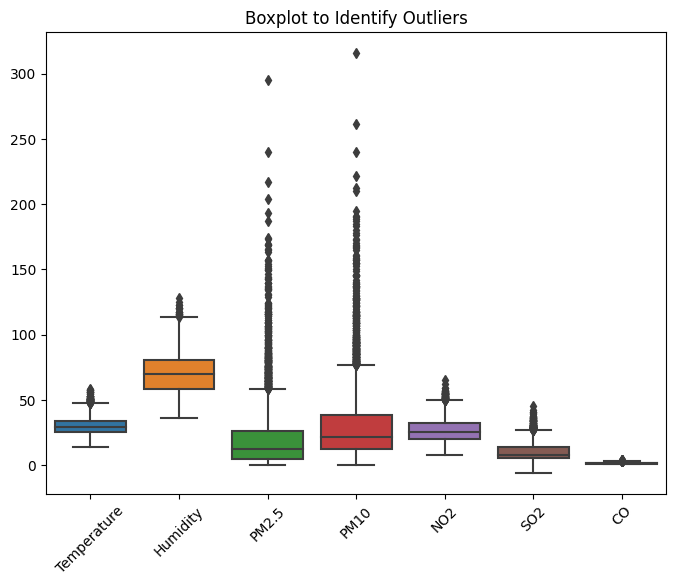

In [ ]:
ax=plt.figure(figsize=(8, 6))
sns.boxplot(data.drop(['Proximity_to_Industrial_Areas', 'Population_Density', 'Air Quality'],axis=1))
plt.xticks(rotation=45)
plt.title('Boxplot to Identify Outliers')
plt.show()

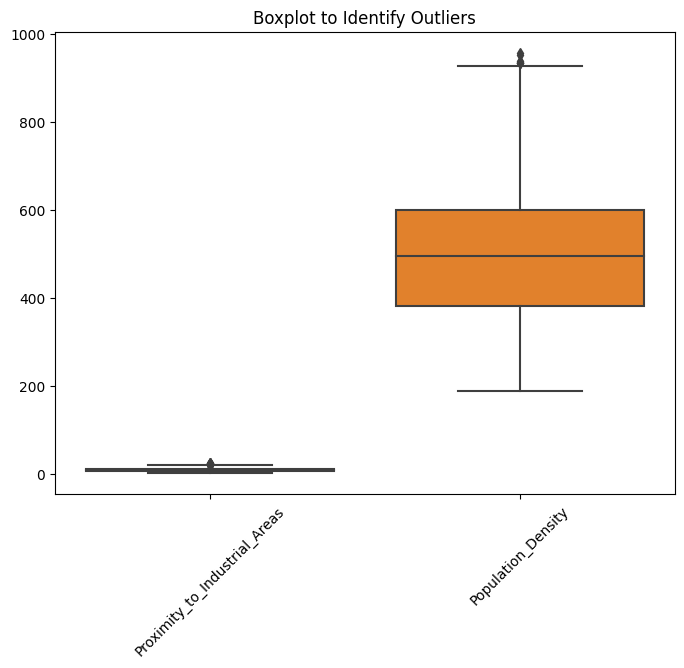

In [47]:
ax=plt.figure(figsize=(8, 6))
sns.boxplot(data.drop(['Temperature', 'Humidity', 'PM2.5', 'PM10', 'NO2', 'SO2', 'CO', 'Air Quality'],axis=1))
plt.xticks(rotation=45)
plt.title('Boxplot to Identify Outliers')
plt.show()

Pie chart for classes distribution

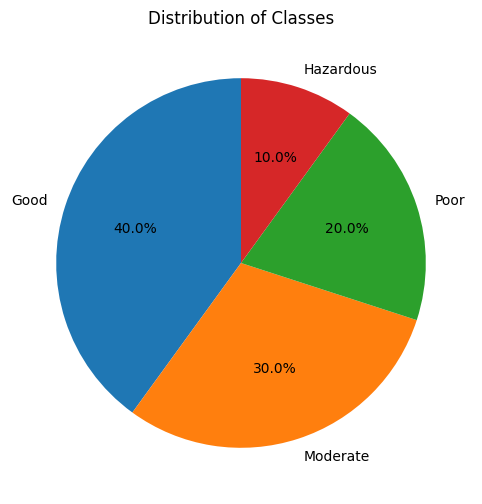

In [15]:
classes=data['Air Quality'].value_counts()
plt.figure(figsize=(8, 6))
plt.pie(data['Air Quality'].value_counts(), labels=classes.index, autopct='%1.1f%%', startangle=90)
plt.title('Distribution of Classes')
plt.show()

Heatmap for finding relations between columns

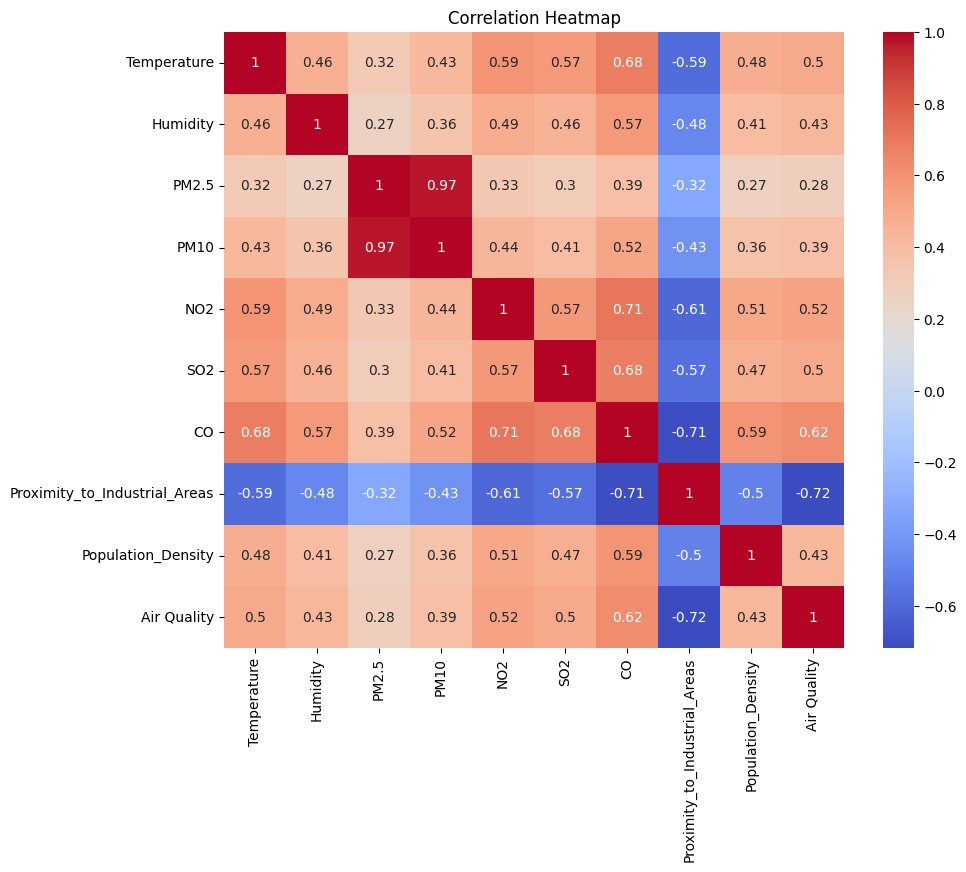

In [45]:
plt.figure(figsize=(10, 8))
sns.heatmap(data.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

# Preprocessing

Remove outliers

In [13]:
data=data[data['PM2.5']<=170]
data=data[data['PM10']<=200]

Encoding

In [14]:
label_encoder = preprocessing.LabelEncoder()
data['Air Quality']=label_encoder.fit_transform(data['Air Quality'])
#for dataset with outliers
copy['Air Quality']=label_encoder.fit_transform(copy['Air Quality'])

# Helper methods

these methods are used to handle all operations implemented on the data

In [62]:
def classification_report_test(x_test,y_test,model):
    classes=['Good','Moderate','Poor','Hazardous']
    return classification_report(y_test,model.predict(x_test),target_names=classes,output_dict=True)

# Pipeline Models

In [11]:
xgb_pipeline=Pipeline([('std_scaler', StandardScaler()),
                       ('xgb_model',XGBClassifier())])
catboost_pipeline=Pipeline([('std_scaler', StandardScaler()),
                       ('catboost_model',CatBoostClassifier())])      
lgbm_pipeline=Pipeline([('std_scaler', StandardScaler()),
                       ('lightgbm_model',LGBMClassifier())])

model_pipelines={
    'xgboost':xgb_pipeline,
    'catboost':catboost_pipeline,
    'lightgbm':lgbm_pipeline
}                       

dataset with outliers and unbalanced data

In [16]:
Y=data['Air Quality']
X=data.drop(['Air Quality'],axis=1)

dataset without outliers and unbalanced data

In [75]:
YC=copy['Air Quality']
XC=copy.drop(['Air Quality'],axis=1)

dataset without outliers and balanced data

In [76]:
over = SMOTE(sampling_strategy='minority')
under = RandomUnderSampler(sampling_strategy={0:1500,1:1500,2:1000,3:999})
X_re, Y_re = over.fit_resample(X, Y)
X_re, Y_re=under.fit_resample(X_re,Y_re)  

dataset with outliers and balanced data

In [77]:
XC_re, YC_re = over.fit_resample(XC, YC)
XC_re, YC_re=under.fit_resample(XC_re,YC_re)  

# MLFLOW

# Experments explained:

There will be 4 experments running :

1-using unbalanced data and removed outliers.

2-using balanced data and removed outliers.

3-using unbalanced data and outliers kept.

4-using balanced data and outliers kept.

In [ ]:

expermints={
    'unbalanced_data':[[X,Y],model_pipelines],
    'balanced_data': [[X_re,Y_re],model_pipelines],
    'outliers_kept_unbalanced_data':[[XC,YC],model_pipelines],
    'outliers_kept_balanced_data':[[XC_re,YC_re],model_pipelines]}


Run the mlflow

In [ ]:
for m in ['xgboost','catboost','lightgbm']:
    for key,exp in expermints.items():
        with mlflow.start_run(nested=True,run_name=m+' '+key):
                  X=expermints[key][0][0]#get the X according to type of data
                  Y=expermints[key][0][1]#get the Y according to type of data                  
                  model=expermints[key][1][m]#defines which pipeline is running

                  #split data
                  x_train,x_test,y_train,y_test=train_test_split(X,Y,test_size=0.2,random_state=42)
                  trained_model=model.fit(x_train,y_train)
                  pred=model.predict(x_test)
                  #train models on train data
                  trained_model=model.fit(x_train,y_train)#train model                                  
                  #caculate testing metrics
                  test_f1=f1_score(y_test,pred,average='weighted')#get f1 score                                           
                  rec=recall_score(y_test,pred,average='weighted')#get recall score
                  precision=precision_score(y_test,pred,average='weighted')#get the precision score
                  cls_report=classification_report_test(x_test,y_test,trained_model)#get the classification report
                  acc=cls_report['accuracy']#get the accuracy found in the classification report
                  
                  #add mlflow parameters
                  mlflow.log_metric('accuracy',acc)#add the accuracy of each model on the test data
                  mlflow.log_metric('f1_score',test_f1)#add te f1 score
                  mlflow.log_metric('recall_score',rec)#add the recall score
                  mlflow.log_metric('precision_score',precision)#add the precision score              
                  mlflow.sklearn.log_model(model, m+' '+key)#add the model
                                    

# Results
Model with best performance is XGBoost for unbalanced data with outliers are kept or removed  

# Test model

In [6]:
logged_model = 'runs:/4dcd14e040814a03b5bf0330dc2e2c38/xgboost unbalanced_data'

# Load model as a PyFuncModel.
loaded_model = mlflow.pyfunc.load_model(logged_model)

# Predict on a Pandas DataFrame.
import pandas as pd
loaded_model.predict(pd.DataFrame(np.array([[1,0,2,1,0,1,0,0,0]])))

c:\Users\Windows.10\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\base.py:451: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  "X does not have valid feature names, but"


array([2], dtype=int64)